### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 6


### Дисциплина: Методы машинного обучения

In [2]:
"""
import tensorflow as tf

# Explicitly allow memory growth to avoid allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Physical GPUs:", len(gpus))
        print("Logical GPUs:", len(logical_gpus))
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print(gpus)
"""

'\nimport tensorflow as tf\n\n# Explicitly allow memory growth to avoid allocating all GPU memory at once\ngpus = tf.config.list_physical_devices(\'GPU\')\nif gpus:\n    try:\n        # Currently, memory growth needs to be the same across GPUs\n        for gpu in gpus:\n            tf.config.experimental.set_memory_growth(gpu, True)\n        logical_gpus = tf.config.experimental.list_logical_devices(\'GPU\')\n        print("Physical GPUs:", len(gpus))\n        print("Logical GPUs:", len(logical_gpus))\n    except RuntimeError as e:\n        # Memory growth must be set before GPUs have been initialized\n        print(e)\nelse:\n    print(gpus)\n'

##### Студент:  Яссин Мохамад Аламин
##### Группа:   НКНбд-01-20

## Москва 2023
***

# Вариант №28
Лабораторная работа 6

## Текст задания:

1. Набор данных deep_weeds 

2. Классы с метками 2,4,6 


## Решение:

In [3]:
import random
random.seed(42)
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
import tensorflow_datasets as tfds

### 1. Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки.



В deep_weeds `split=["train,"test"]` не подходит, поэтмому я так разелю датасет

In [4]:
# Load dataset
dataset = tfds.load("deep_weeds", split='train')
df = tfds.as_dataframe(dataset)

# Split dataset into train and test
split_size = int(df.shape[0] * 0.25)
df_train = df[split_size:]
df_test = df[:split_size]

In [5]:
# Check shapes of train and test datasets
train_shape = df_train.shape
test_shape = df_test.shape
print(f"Train dataset shape: {train_shape}")
print(f"Test dataset shape: {test_shape}")
print(f"Shape of the first image in the train dataset: {df_train.iloc[0]['image'].shape}")

Train dataset shape: (13132, 2)
Test dataset shape: (4377, 2)
Shape of the first image in the train dataset: (256, 256, 3)


### 2. Визуализируйте несколько изображений, отобранных случайным образом из обучающей выборки.


In [6]:
def plot_random_sample(images):
    n = 10
    imgs = random.sample(list(images), n)
    
    num_row = 2
    num_col = 5 

    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))
    # For every image
    for i in range(num_row * num_col):
        # Read the image
        img = imgs[i] 
        # Display the image
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)

    plt.tight_layout()
    plt.show()

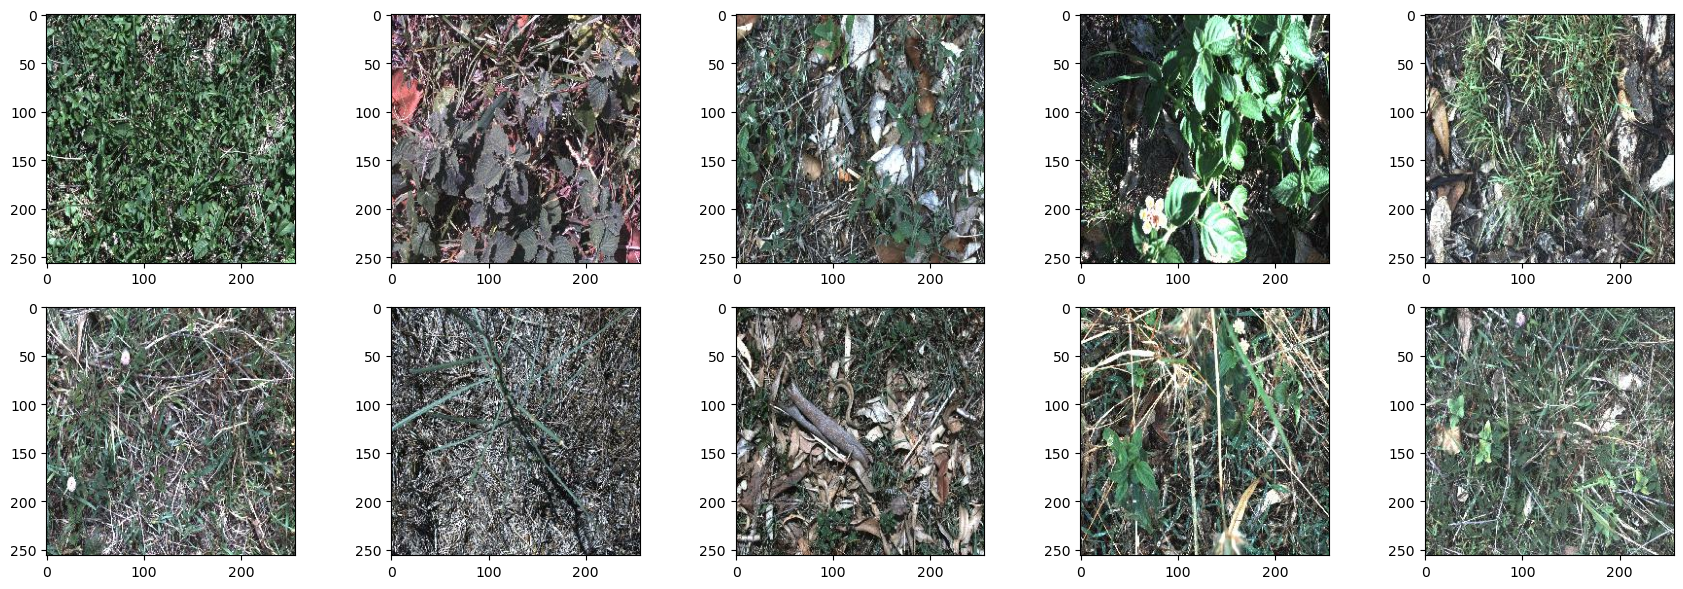

In [7]:
plot_random_sample(df_train['image'])

### 3. Оставьте в наборе изображения двух классов, указанных в индивидуальном задании первыми. Обучите нейронные сети MLP и CNN задаче бинарной классификации изображений (архитектура сетей по вашему усмотрению).  



* Swtiching shape to `[batches,size,size,channels]`

In [8]:
df_train_filtered = df_train[df_train['label'].isin([2, 4])]
train_labels = df_train_filtered['label'].to_numpy(dtype=np.float32)
train_labels_shape = train_labels.shape
train_images = np.zeros(shape=(train_labels_shape[0], 256, 256, 3), dtype=np.float32)
for idx in range(train_labels_shape[0]):
    train_images[idx, :, :, :] = np.array(Image.fromarray(df_train_filtered.iloc[idx]['image']))

train_images_shape = train_images.shape
print(f"Train images shape: {train_images_shape}")

df_test_filtered = df_test[df_test['label'].isin([2, 4])]
test_labels = df_test_filtered['label'].to_numpy(dtype=np.float32)
test_labels_shape = test_labels.shape
test_images = np.zeros(shape=(test_labels_shape[0], 256, 256, 3), dtype=np.float32)
for idx in range(test_labels_shape[0]):
    test_images[idx, :, :, :] = np.array(Image.fromarray(df_test_filtered.iloc[idx]['image']))

test_images_shape = test_images.shape
print(f"Test images shape: {test_images_shape}")


Train images shape: (1573, 256, 256, 3)
Test images shape: (520, 256, 256, 3)


In [9]:
#norm
train_images=train_images/255
test_images=test_images/255
# converting labels from 2,4 to 0,1 
train_labels = (train_labels - 2) / 2
test_labels = (test_labels - 2) / 2

In [10]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

history_1 = model_1.fit(
    train_images,
    train_labels,
    epochs=10,
    batch_size=128,
    validation_data=(test_images, test_labels)
)

Epoch 1/10
13/13 [==============================] - 7s 420ms/step - loss: 9.7224 - accuracy: 0.5137 - val_loss: 1.0075 - val_accuracy: 0.4904
Epoch 2/10
13/13 [==============================] - 5s 425ms/step - loss: 4.2552 - accuracy: 0.4806 - val_loss: 0.7120 - val_accuracy: 0.5135
Epoch 3/10
13/13 [==============================] - 5s 422ms/step - loss: 1.0754 - accuracy: 0.5092 - val_loss: 0.6905 - val_accuracy: 0.5096
Epoch 4/10
13/13 [==============================] - 5s 412ms/step - loss: 0.6933 - accuracy: 0.4901 - val_loss: 0.6926 - val_accuracy: 0.5058
Epoch 5/10
13/13 [==============================] - 5s 419ms/step - loss: 0.6940 - accuracy: 0.4800 - val_loss: 0.6912 - val_accuracy: 0.5058
Epoch 6/10
13/13 [==============================] - 6s 441ms/step - loss: 0.6934 - accuracy: 0.5175 - val_loss: 0.6905 - val_accuracy: 0.5019
Epoch 7/10
13/13 [==============================] - 5s 421ms/step - loss: 0.6923 - accuracy: 0.5124 - val_loss: 0.6900 - val_accuracy: 0.5019
Epoch 

In [11]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

history_2 = model_2.fit(
    train_images.reshape(-1, 256, 256, 3),
    train_labels,
    epochs=10,
    batch_size=128,
    validation_data=(test_images.reshape(-1, 256, 256, 3), test_labels)
)

Epoch 1/10
13/13 [==============================] - 309s 21s/step - loss: 1.7287 - accuracy: 0.5149 - val_loss: 0.6810 - val_accuracy: 0.4942
Epoch 2/10
13/13 [==============================] - 270s 21s/step - loss: 0.6767 - accuracy: 0.5359 - val_loss: 0.6878 - val_accuracy: 0.4942
Epoch 3/10
13/13 [==============================] - 249s 19s/step - loss: 0.6654 - accuracy: 0.5588 - val_loss: 0.6458 - val_accuracy: 0.5154
Epoch 4/10
13/13 [==============================] - 185s 14s/step - loss: 0.6237 - accuracy: 0.5931 - val_loss: 0.6120 - val_accuracy: 0.5788
Epoch 5/10
13/13 [==============================] - 232s 18s/step - loss: 0.6026 - accuracy: 0.6910 - val_loss: 0.5796 - val_accuracy: 0.7231
Epoch 6/10
13/13 [==============================] - 283s 21s/step - loss: 0.5420 - accuracy: 0.7502 - val_loss: 0.5790 - val_accuracy: 0.7192
Epoch 7/10
13/13 [==============================] - 288s 22s/step - loss: 0.4618 - accuracy: 0.7972 - val_loss: 0.4574 - val_accuracy: 0.7846
Epoch 


### 4. Постройте кривые обучения нейронных сетей бинарной классификации для показателей ошибки и доли верных ответов в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.



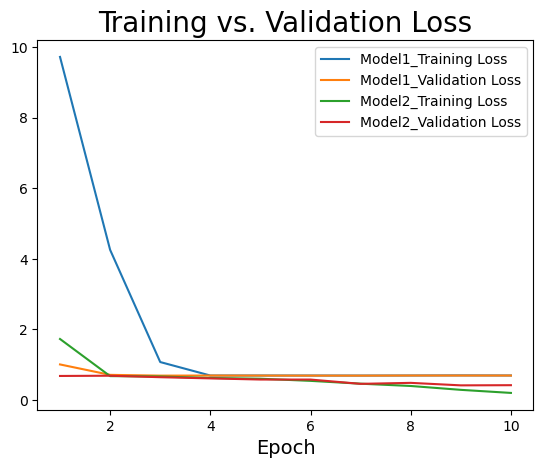

In [12]:
plt.plot(np.arange(1, 11), history_1.history['loss'], label='Model1_Training Loss')
plt.plot(np.arange(1, 11), history_1.history['val_loss'], label='Model1_Validation Loss')
plt.plot(np.arange(1, 11), history_2.history['loss'], label='Model2_Training Loss')
plt.plot(np.arange(1, 11), history_2.history['val_loss'], label='Model2_Validation Loss')
plt.title('Training vs. Validation Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

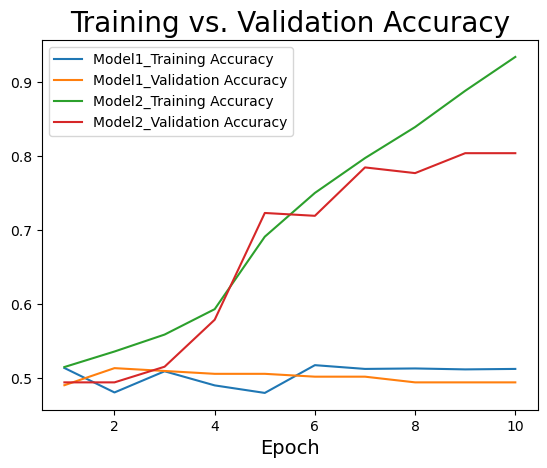

In [13]:
plt.plot(np.arange(1, 11), history_1.history['accuracy'], label='Model1_Training Accuracy')
plt.plot(np.arange(1, 11), history_1.history['val_accuracy'], label='Model1_Validation Accuracy')
plt.plot(np.arange(1, 11), history_2.history['accuracy'], label='Model2_Training Accuracy')
plt.plot(np.arange(1, 11), history_2.history['val_accuracy'], label='Model2_Validation Accuracy')
plt.title('Training vs. Validation Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();


### 5. Сравните качество бинарной классификации нейронными сетями при помощи матрицы ошибок для тестовой выборки. 


17/17 [==============================] - 9s 527ms/step


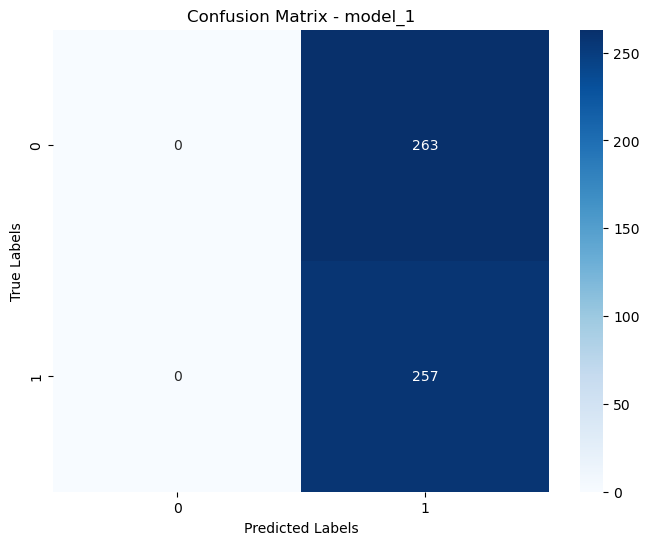

In [16]:
# Predict probabilities for test data
y_pred_prob_1 = model_1.predict(test_images)

# Convert probabilities to binary predictions
y_pred_1 = (y_pred_prob_1 > 0.5).astype(int)

# Compute confusion matrix
cm_1 = confusion_matrix(test_labels, y_pred_1)

# Predict probabilities for test data
y_pred_prob_2 = model_2.predict(test_images)

# Convert probabilities to binary predictions
y_pred_2 = (y_pred_prob_2 > 0.5).astype(int)

# Compute confusion matrix
cm_2 = confusion_matrix(test_labels, y_pred_2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - model_1')
plt.show()

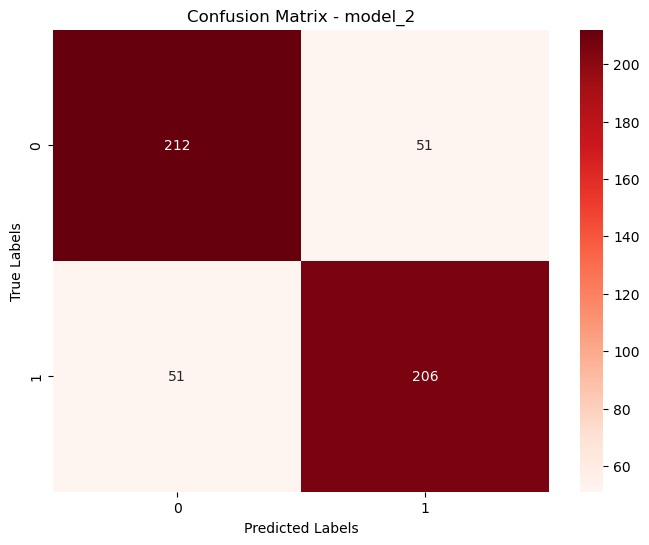

In [18]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - model_2')
plt.show()

### 6. Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) и вычислите площади под ROC-кривыми.


17/17 [==============================] - 9s 505ms/step


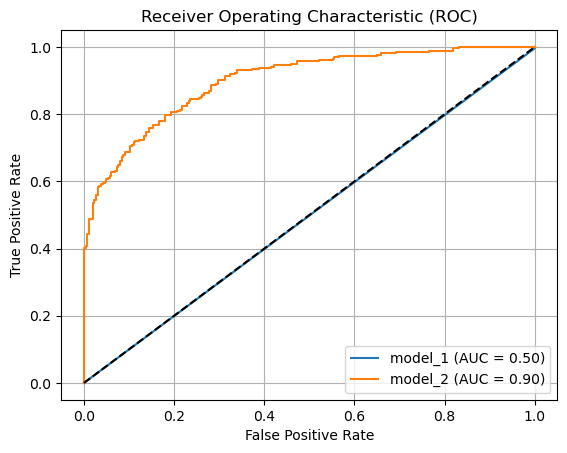

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for test data
y_pred_prob_1 = model_1.predict(test_images)
y_pred_prob_2 = model_2.predict(test_images)

# Compute ROC curves
fpr_1, tpr_1, _ = roc_curve(test_labels, y_pred_prob_1)
fpr_2, tpr_2, _ = roc_curve(test_labels, y_pred_prob_2)

# Compute AUC scores
auc_1 = roc_auc_score(test_labels, y_pred_prob_1)
auc_2 = roc_auc_score(test_labels, y_pred_prob_2)

# Plot ROC curves
plt.plot(fpr_1, tpr_1, label='model_1 (AUC = {:.2f})'.format(auc_1))
plt.plot(fpr_2, tpr_2, label='model_2 (AUC = {:.2f})'.format(auc_2))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### 7. Оставьте в наборе изображения трех классов, указанных в индивидуальном задании. Обучите нейронные сети MLP и CNN задаче многоклассовой классификации изображений (архитектура сетей по вашему усмотрению). 




In [20]:
# Free some memory
del df_train_filtered
del train_labels
del train_images
del df_test_filtered
del test_labels
del test_images

In [21]:
import numpy as np
from PIL import Image

def image_generator(data_frame):
    for idx in range(data_frame.shape[0]):
        image = np.array(Image.fromarray(data_frame.iloc[idx]['image']))
        image = image / 255.0  # normalize image values
        label = (data_frame.iloc[idx]['label'] - 2) // 2  # convert label from 2, 4, 6 to 0, 1, 2
        yield image, label

# Training data
df_train_filtered = df_train[df_train['label'].isin([2, 4, 6])]
train_images = []
train_labels = []
for image, label in image_generator(df_train_filtered):
    train_images.append(image)
    train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

print(f"Train images shape: {train_images.shape}")
print(f"Train labels: {train_labels}")

# Testing data
df_test_filtered = df_test[df_test['label'].isin([2, 4, 6])]
test_images = []
test_labels = []
for image, label in image_generator(df_test_filtered):
    test_images.append(image)
    test_labels.append(label)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

print(f"test images shape: {test_images.shape}")
print(f"test labels: {test_labels[:3]}")

Train images shape: (2387, 256, 256, 3)
Train labels: [1 2 1 ... 0 2 2]
test images shape: (780, 256, 256, 3)
test labels: [2 1 1]


In [22]:
del df_train_filtered
del df_test_filtered
del df_train
del df_test

In [23]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_3.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_3 = model_3.fit(
    train_images,
    train_labels,
    epochs=10,
    batch_size=128,
    validation_data=(test_images, test_labels)
)

Epoch 1/10
19/19 [==============================] - 18s 706ms/step - loss: 15.4220 - accuracy: 0.3414 - val_loss: 1.3258 - val_accuracy: 0.3333
Epoch 2/10
19/19 [==============================] - 8s 439ms/step - loss: 1.4411 - accuracy: 0.3289 - val_loss: 1.0988 - val_accuracy: 0.3295
Epoch 3/10
19/19 [==============================] - 8s 434ms/step - loss: 1.1054 - accuracy: 0.3356 - val_loss: 1.0987 - val_accuracy: 0.3295
Epoch 4/10
19/19 [==============================] - 8s 441ms/step - loss: 1.0990 - accuracy: 0.3372 - val_loss: 1.0987 - val_accuracy: 0.3295
Epoch 5/10
19/19 [==============================] - 8s 437ms/step - loss: 1.1056 - accuracy: 0.3368 - val_loss: 1.0987 - val_accuracy: 0.3295
Epoch 6/10
19/19 [==============================] - 9s 461ms/step - loss: 1.0982 - accuracy: 0.3372 - val_loss: 1.0988 - val_accuracy: 0.3295
Epoch 7/10
19/19 [==============================] - 8s 439ms/step - loss: 1.1035 - accuracy: 0.3364 - val_loss: 1.0988 - val_accuracy: 0.3295
Epoc

In [24]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_4.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_4 = model_4.fit(
    train_images.reshape(-1, 256, 256, 3),+
    train_labels,
    epochs=10,
    batch_size=64,
    validation_data=(test_images.reshape(-1, 256, 256, 3), test_labels)
)

Epoch 1/10
38/38 [==============================] - 280s 7s/step - loss: 2.0664 - accuracy: 0.4093 - val_loss: 1.0287 - val_accuracy: 0.3423
Epoch 2/10
38/38 [==============================] - 256s 7s/step - loss: 0.9089 - accuracy: 0.6192 - val_loss: 0.8009 - val_accuracy: 0.6769
Epoch 3/10
38/38 [==============================] - 251s 7s/step - loss: 0.7695 - accuracy: 0.6590 - val_loss: 0.7609 - val_accuracy: 0.6526
Epoch 4/10
38/38 [==============================] - 252s 7s/step - loss: 0.6378 - accuracy: 0.7084 - val_loss: 0.6680 - val_accuracy: 0.6462
Epoch 5/10
38/38 [==============================] - 253s 7s/step - loss: 0.6017 - accuracy: 0.7210 - val_loss: 0.5299 - val_accuracy: 0.7705
Epoch 6/10
38/38 [==============================] - 252s 7s/step - loss: 0.5444 - accuracy: 0.7512 - val_loss: 0.5527 - val_accuracy: 0.7154
Epoch 7/10
38/38 [==============================] - 252s 7s/step - loss: 0.5077 - accuracy: 0.7755 - val_loss: 0.5312 - val_accuracy: 0.7628
Epoch 8/10
38

### 8. Сравните качество многоклассовой классификации нейронными сетями при помощи матрицы ошибок (для трех классов) для тестовой выборки. 


25/25 [==============================] - 15s 584ms/step


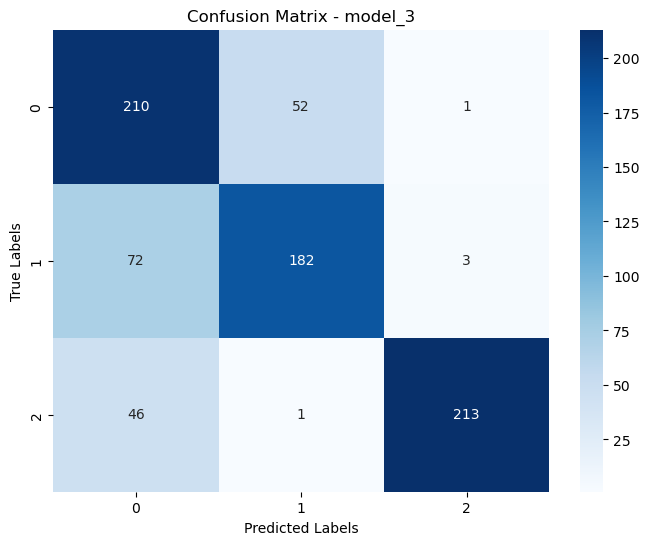

In [25]:
# Predict probabilities for test data
test_predictions = model_3.predict(test_images.reshape(-1, 256, 256, 3))
test_predictions = np.argmax(test_predictions, axis=1)
test_predictions = model_4.predict(test_images.reshape(-1, 256, 256, 3))
test_predictions = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm_3 = confusion_matrix(test_labels, test_predictions)
cm_4 = confusion_matrix(test_labels, test_predictions)



# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - model_3')
plt.show()

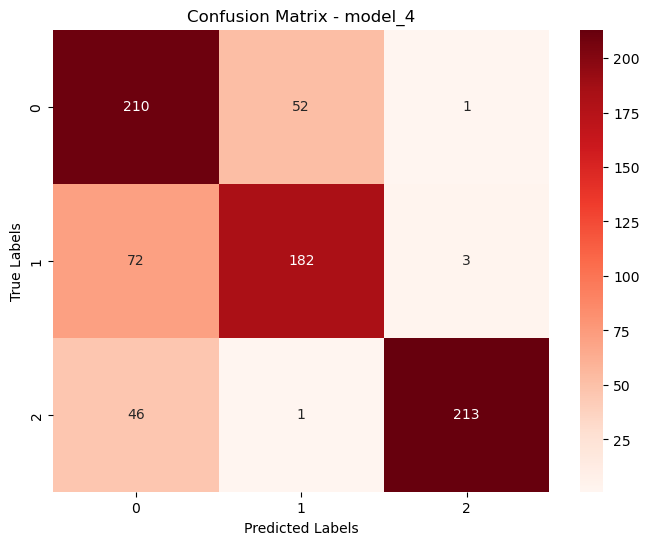

In [26]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_4, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - model_4')
plt.show()

### 9. Постройте кривые обучения нейронных сетей многоклассовой классификации для показателей ошибки и доли верных ответов в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.



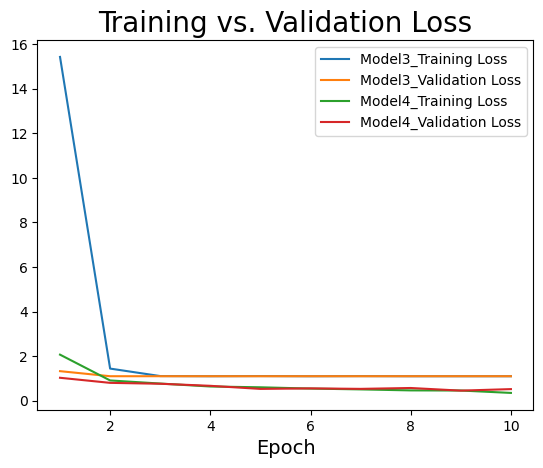

In [27]:
plt.plot(np.arange(1, 11), history_3.history['loss'], label='Model3_Training Loss')
plt.plot(np.arange(1, 11), history_3.history['val_loss'], label='Model3_Validation Loss')
plt.plot(np.arange(1, 11), history_4.history['loss'], label='Model4_Training Loss')
plt.plot(np.arange(1, 11), history_4.history['val_loss'], label='Model4_Validation Loss')
plt.title('Training vs. Validation Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

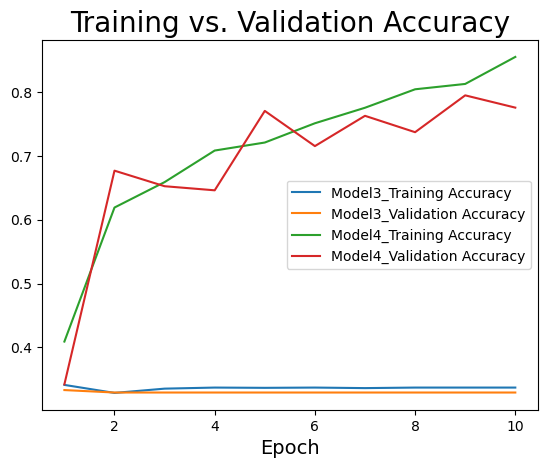

In [28]:
plt.plot(np.arange(1, 11), history_3.history['accuracy'], label='Model3_Training Accuracy')
plt.plot(np.arange(1, 11), history_3.history['val_accuracy'], label='Model3_Validation Accuracy')
plt.plot(np.arange(1, 11), history_4.history['accuracy'], label='Model4_Training Accuracy')
plt.plot(np.arange(1, 11), history_4.history['val_accuracy'], label='Model4_Validation Accuracy')
plt.title('Training vs. Validation Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();